In [1]:
import os
import glob
import json
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import statsmodels.stats.multitest

import cubnm_paper

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

thcolor = '#44546A'

# Collect JSONs

In [2]:
jsons_data = []
for machine in ['raven', 'pc']:
    json_files = glob.glob(os.path.join(
        cubnm_paper.config.DATA_DIR, 
        'scaling', machine, '*.json'
    ))
    for json_file in json_files:
        with open(json_file, "r") as f:
            jsons_data.append(json.load(f))
            
data = pd.DataFrame(jsons_data)

# calculate total time
data['total_time'] = data['init_time'] + data['run_time']

# sort
data = data.sort_values([
    'machine', 'use_cpu', 'cpu_cores', 'N', 'nodes', 'repeat', 'full_SC']
).reset_index(drop=True)

# set the GPU models
data.loc[
    (data['machine']=='raven') & (~data['use_cpu']), 'Hardware'
] = 'A100 GPU'
data.loc[
    (data['machine']=='pc') & (~data['use_cpu']), 'Hardware'
] = '4080 Super GPU'

# save
data.to_csv(os.path.join(cubnm_paper.config.DATA_DIR, 'scaling.csv'))

data

,machine,N,duration,nodes,node_scaling,co_launch,full_SC,dt,repeat,version,use_cpu,cpu_cores,init_time,run_time,first_last_equal,total_time,Hardware
0,pc,1,60,10,True,False,True,1.0,0,0.1.0rc1+2.g2d4c488,False,16,0.083063,0.400930,True,0.483993,4080 Super GPU
1,pc,1,60,10,True,False,True,1.0,1,0.1.0rc1+2.g2d4c488,False,16,0.010151,0.392399,True,0.402550,4080 Super GPU
2,pc,1,60,100,False,False,False,0.1,0,0.1.0rc1+2.g2d4c488,False,16,0.984158,4.524239,True,5.508397,4080 Super GPU
3,pc,1,60,100,True,False,True,1.0,0,0.1.0rc1+2.g2d4c488,False,16,0.155593,0.900678,True,1.056271,4080 Super GPU
4,pc,1,60,100,False,False,False,0.1,1,0.1.0rc1+2.g2d4c488,False,16,0.942519,4.546614,True,5.489134,4080 Super GPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,raven,64,60,100,False,False,False,0.1,1,0.1.0rc1+2.g2d4c488,True,144,2.921105,10.143097,True,13.064202,NaN
118,raven,128,60,100,False,False,False,0.1,0,0.1.0rc1+2.g2d4c488,True,144,2.891980,18.299050,True,21.191031,NaN
119,raven,128,60,100,False,False,False,0.1,1,0.1.0rc1+2.g2d4c488,True,144,2.895735,18.189535,True,21.085270,NaN
120,raven,256,60,100,False,False,False,0.1,0,0.1.0rc1+2.g2d4c488,True,144,2.903604,36.545965,True,39.449569,NaN


# Calculate Scaling with N

In [3]:
N_data = data[
    (data['duration']==60) & 
    (data['nodes']==100) &
    (data['dt']==0.1) &
    (~data['full_SC']) &
    (~data['node_scaling'].fillna(False))
].copy()


N_data.loc[(N_data['use_cpu'] & (N_data['cpu_cores']<=1)), 'Hardware'] = '1 CPU Thread'
N_data.loc[(N_data['use_cpu'] & (N_data['cpu_cores']>1)), 'Hardware'] = '72 CPU Cores'

# select 2 elements per (N, Hardware) combination
N_data = N_data.groupby(['N', 'Hardware']).apply(lambda x: x.head(2)).reset_index(drop=True)
# confirm 2 is selected for each combination
assert (N_data.groupby(['N', 'Hardware'])['total_time'].count() == 2).all()
# take the min value
N_data = N_data.groupby(['N', 'Hardware'])[['total_time', 'run_time', 'init_time']].mean('total_time').reset_index()

N_data.head()

,N,Hardware,total_time,run_time,init_time
0,1,1 CPU Thread,13.093747,10.198683,2.895064
1,1,4080 Super GPU,5.498765,4.535427,0.963338
2,1,72 CPU Cores,13.116069,10.228350,2.887719
3,1,A100 GPU,5.272636,2.061226,3.211410
4,2,1 CPU Thread,23.341940,20.452842,2.889098


Extrapolate CPU times up to 2^15, assuming linear growth:

In [4]:
max_Ns = N_data.groupby('Hardware')['N'].max()
max_logNs = np.log2(max_Ns).astype(int)
max_logN = max(max_logNs)
N_extra = []
for hardware, df in N_data.groupby('Hardware'):
    # include last N to create the linking line between real and extrapolated
    N_extra.append(df.iloc[-1].to_dict())
    init_time = df.iloc[-1]['init_time']
    run_time = df.iloc[-1]['run_time']
    # add extrapolated points
    for logN in range(max_logNs[hardware]+1, max_logN+1):
        N_extra.append({
            'N': 2**logN,
            'Hardware': hardware,
            'init_time': init_time,
            'run_time': run_time * 2 ** (logN - max_logNs[hardware]),
        })
N_extra = pd.DataFrame(N_extra)
N_extra['total_time'] = N_extra['init_time'] + N_extra['run_time']
N_extra.head()

,N,Hardware,total_time,run_time,init_time
0,256,1 CPU Thread,2596.601844,2593.714924,2.88692
1,512,1 CPU Thread,5190.316768,5187.429849,2.88692
2,1024,1 CPU Thread,10377.746617,10374.859698,2.88692
3,2048,1 CPU Thread,20752.606315,20749.719395,2.88692
4,4096,1 CPU Thread,41502.325710,41499.438791,2.88692


Calculate speed up relative to single CPU

In [5]:
single_cpu_time = N_data.loc[(N_data['Hardware']=='1 CPU Thread')&(N_data['N']==1), 'total_time'].values[0]
N_data['speed_up_cpu'] = N_data['N'] / (N_data['total_time'] / single_cpu_time)
N_extra['speed_up_cpu'] = N_extra['N'] / (N_extra['total_time'] / single_cpu_time)

# Calculate Scaling with Nodes

In [6]:
nodes_data = data[
    (data['node_scaling'].fillna(False)) & 
    (data['full_SC'])
].copy()


nodes_data.loc[(nodes_data['use_cpu']), 'Hardware'] = '1 CPU Thread'

# select 2 elements per (N, Hardware) combination
nodes_data = nodes_data.groupby(['nodes', 'Hardware']).apply(lambda x: x.head(2)).reset_index(drop=True)
# confirm 2 is selected for each combination
assert (nodes_data.groupby(['nodes', 'Hardware'])['total_time'].count() == 2).all()
# take the min value
nodes_data = nodes_data.groupby(['nodes', 'Hardware'])[['total_time', 'run_time', 'init_time']].mean('total_time').reset_index()

nodes_data

,nodes,Hardware,total_time,run_time,init_time
0,10,1 CPU Thread,0.113599,0.083487,0.030113
1,10,4080 Super GPU,0.443271,0.396665,0.046607
2,10,A100 GPU,0.511898,0.279521,0.232377
3,100,1 CPU Thread,1.769694,1.479193,0.290501
4,100,4080 Super GPU,1.019749,0.894816,0.124934
5,100,A100 GPU,1.048429,0.390099,0.658330
6,1000,1 CPU Thread,111.287273,108.398106,2.889167
7,1000,4080 Super GPU,5.335382,4.363597,0.971786
8,10000,1 CPU Thread,20848.612470,20819.745315,28.867155
9,10000,4080 Super GPU,88.672367,79.202874,9.469493


/tmp/ipykernel_8408/851340583.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_yticklabels()]))
/tmp/ipykernel_8408/851340583.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/tmp/ipykernel_8408/851340583.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_yticklabels()]))
/tmp/ipykernel_8408/851340583.py:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_y

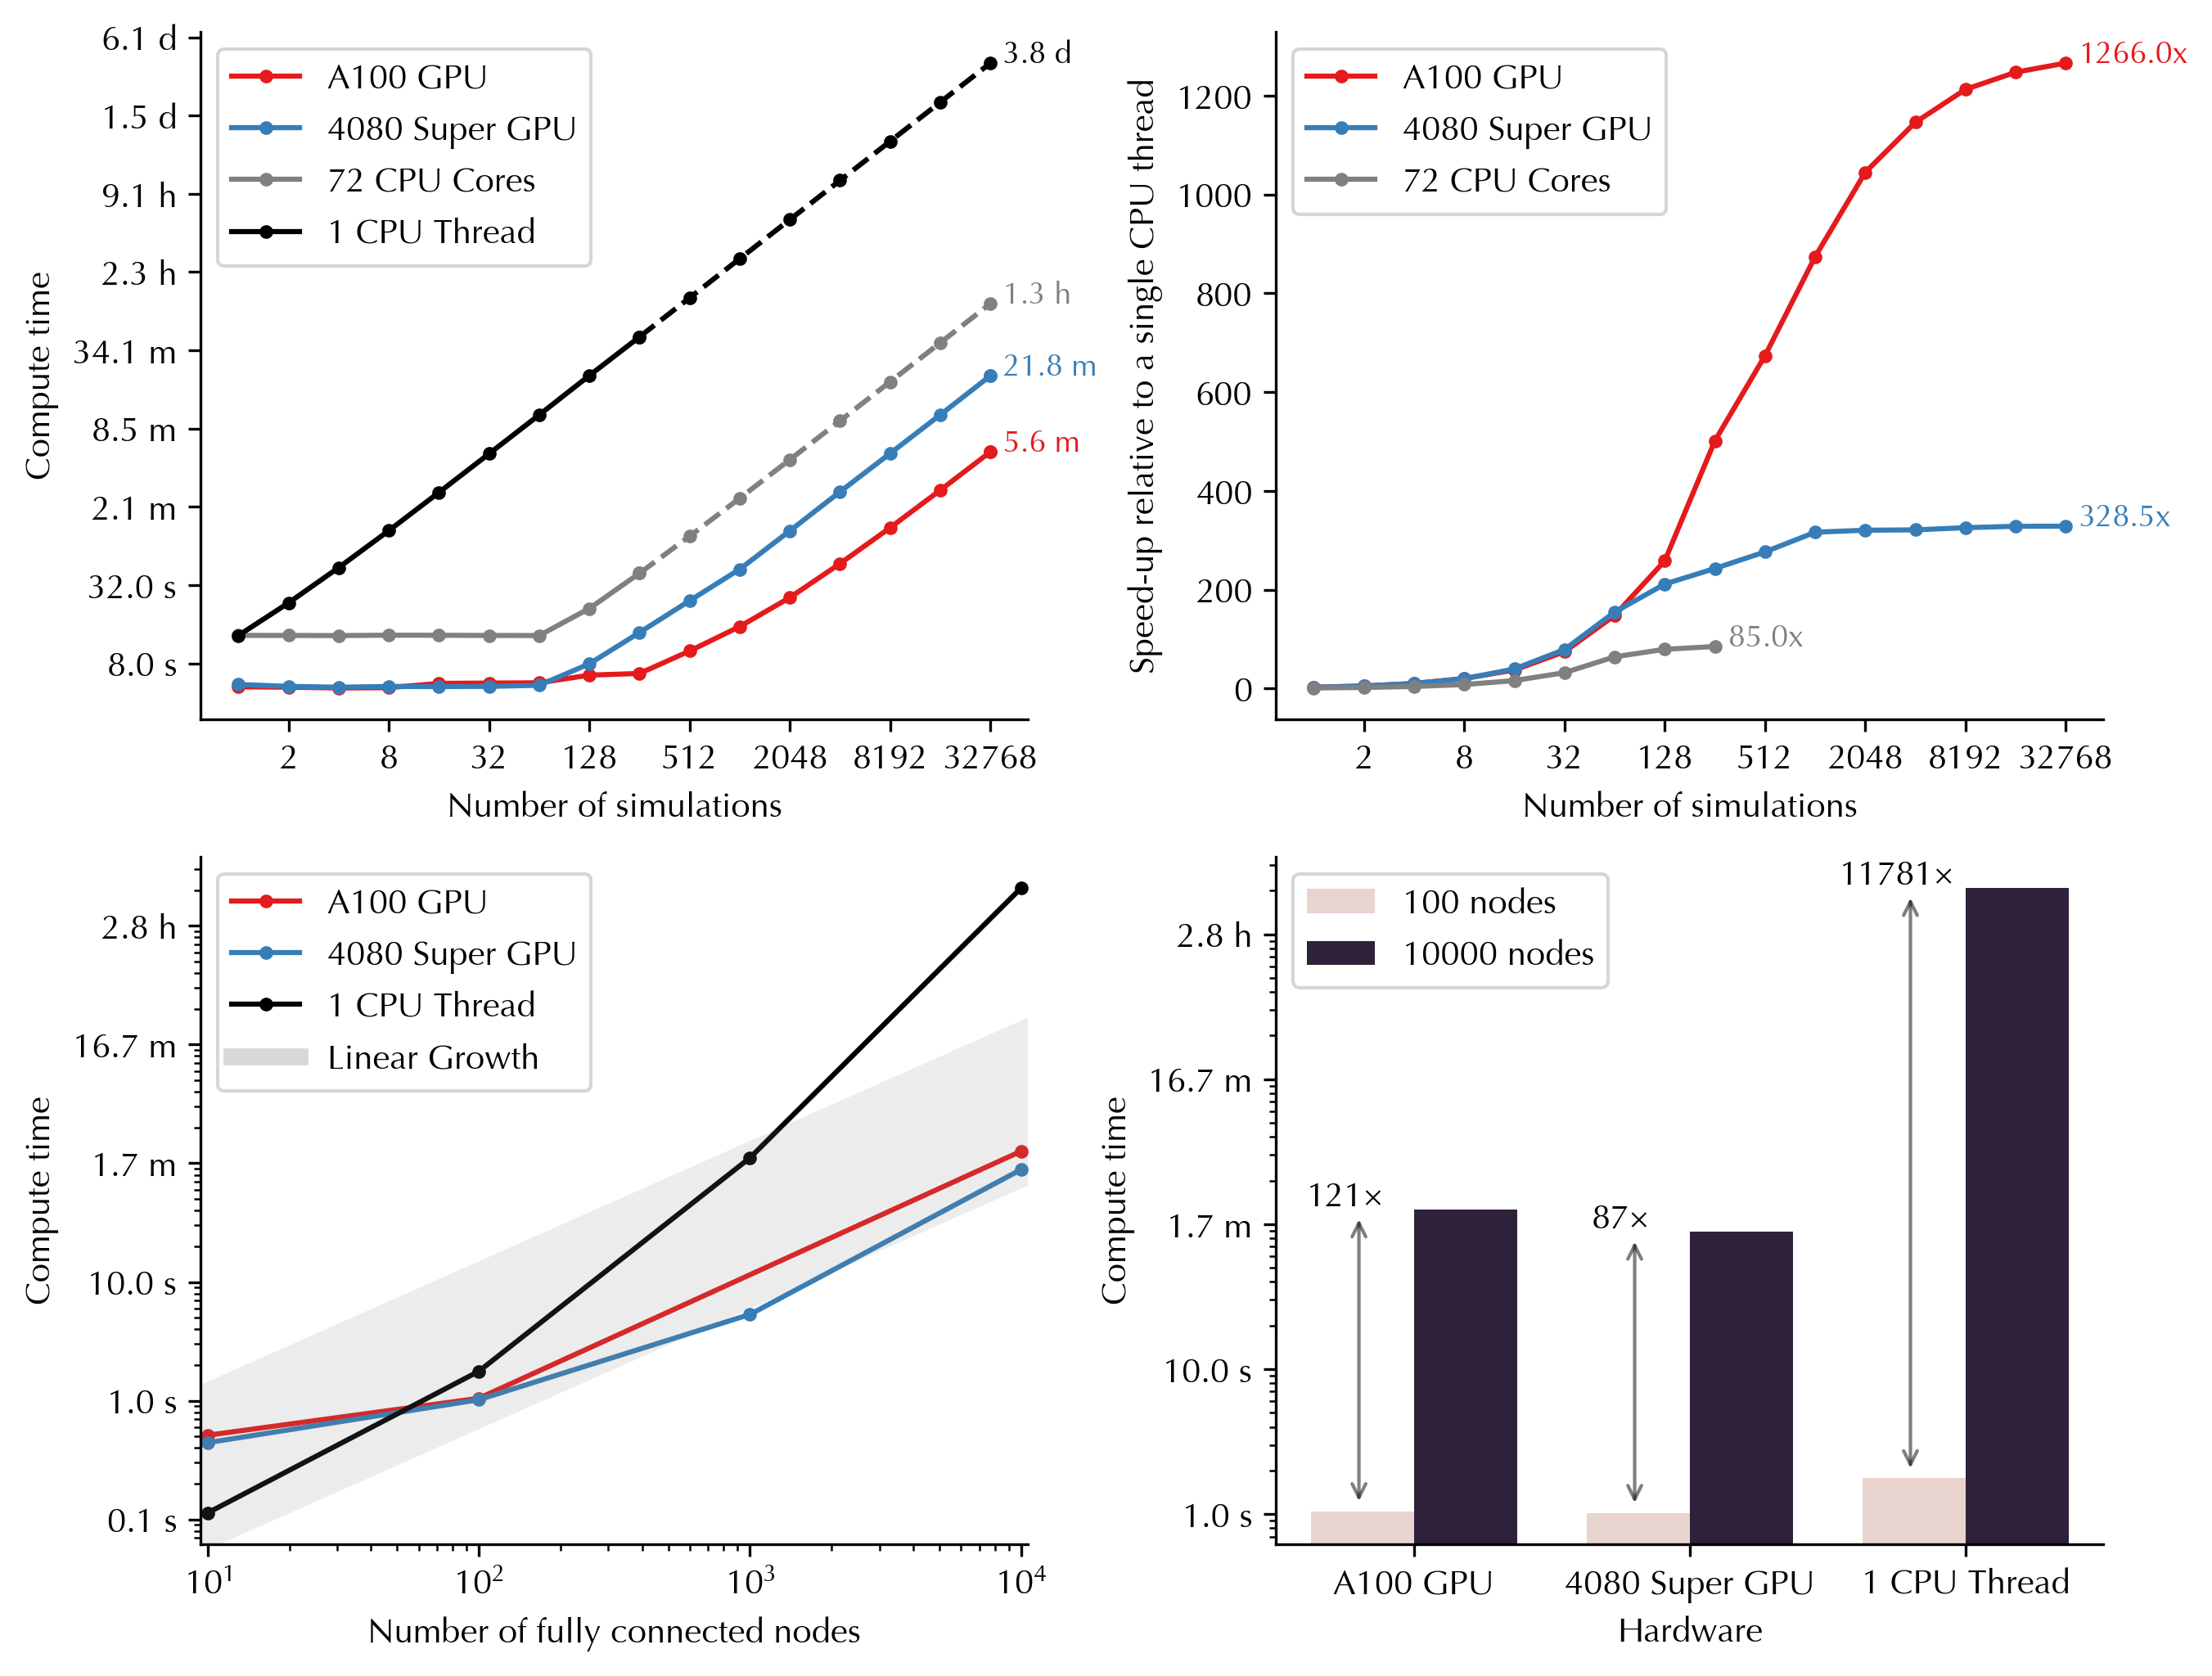

In [8]:
# fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig, axd = plt.subplot_mosaic(
    [
        ["N_scaling", "N_speedup"],
        ["N_scaling", "N_speedup"],
        ["node_scaling", "node_increase"],
        ["node_scaling", "node_increase"],
    ],
    figsize=(10, 8), dpi=300
)


# scaling
ax = axd['N_scaling']

show_theoretical_max_time = True

hardware_order = ['A100 GPU', '4080 Super GPU', '72 CPU Cores', '1 CPU Thread']

colors = sns.color_palette('Set1', len(hardware_order))
colors[-1] = 'black'
colors[-2] = 'grey'
colors_dict = dict(zip(hardware_order, colors))

for i, hardware in enumerate(hardware_order):
    df = N_data.loc[N_data['Hardware']==hardware]
    ax.plot(
        df['N'], 
        df['total_time'],
        label = hardware,
        ls='-',
        marker='.',
        color=colors_dict[hardware],
    )

for i, hardware in enumerate(hardware_order):
    df = N_extra.loc[N_extra['Hardware']==hardware]
    ax.plot(
        df['N'], 
        df['total_time'],
        ls='--',
        marker='.',
        color=colors_dict[hardware]
    )


if show_theoretical_max_time:
    N_all = pd.concat([N_data, N_extra])
    for i, hardware in enumerate(hardware_order):
        max_time = N_all.loc[N_all['Hardware']==hardware, 'total_time'].max()
        ax.annotate(
            cubnm_paper.utils.convert_seconds(max_time),
            xy=(N_all['N'].max()*1.20, max_time*1.0),
            fontsize=9, color=colors_dict[hardware]
        )


ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.set_ylabel('Compute time')
ax.set_xlabel('Number of simulations')
ax.legend(loc='upper left')

# # ax.set_xticklabels([f'{int(a._x)}' for a in ax.get_xticklabels()])
ax.set_xticks(2**np.arange(max_logN+1)[1::2])
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_yticklabels()]))


# Speed-up
ax = axd['N_speedup']
hardware_order = ['A100 GPU', '4080 Super GPU', '72 CPU Cores']

for i, hardware in enumerate(hardware_order):
    df = N_data.loc[N_data['Hardware']==hardware]
    ax.plot(
        df['N'], 
        df['speed_up_cpu'],
        label = hardware,
        ls='-',
        marker='.',
        color=colors_dict[hardware],
    )
    max_speed_up = df['speed_up_cpu'].max()
    max_N = df['N'].max()
    ax.annotate(
        f'{max_speed_up:.1f}x',
        xy=(max_N*1.20, max_speed_up),
        fontsize=9, color=colors_dict[hardware]
    )
    
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of simulations')
ax.set_ylabel('Speed-up relative to a single CPU thread')

ax.set_xticks(2**np.arange(max_logN+1)[1::2])
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.legend(loc='upper left')


# Node-scaling
ax = axd['node_scaling']
hardware_order = ['A100 GPU', '4080 Super GPU', '1 CPU Thread']
for i, hardware in enumerate(hardware_order):
    df = nodes_data.loc[
        (nodes_data['Hardware']==hardware)
    ]
    ax.plot(
        df['nodes'], 
        df['total_time'],
        label = hardware,
        ls='-',
        marker='.',
        color=colors_dict[hardware],
    )
    
# take average of lowest and highest compute times for nodes = 10 as
# a starting point for the reference linear line
time_10 = nodes_data.loc[nodes_data['nodes']==10, 'total_time'].iloc[[0, -1]].mean()
ax.plot(
    [11, 10000], 
    [time_10, time_10 * 1e3],
    ls='-',
    linewidth=45,
    marker=None,
    color='grey',
    alpha=0.15,
)
# + a hidden line only for its label in the legend
# (but with a narrower width and higher alpha, 
# making it look better in the legend)
ax.plot(
    [11, 11], 
    [time_10, time_10],
    ls='-',
    linewidth=5,
    marker=None,
    color='grey',
    alpha=0.3,
    label='Linear Growth',
)

ax.set_ylabel('Compute time')
ax.set_xlabel('Number of fully connected nodes')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_yticklabels()]))
ax.set_xlim([10/(1.06), 10000*(1.06)])
ax.legend(loc='upper left')

### node increase from 100 to 10000
ax = axd['node_increase']
plot_data = nodes_data.loc[nodes_data['nodes'].isin([100, 10000])]
plot_data = plot_data.rename(columns={'nodes': 'Nodes'})
sns.barplot(
    data=plot_data,
    x='Hardware',
    y='total_time',
    hue='Nodes',
    order=hardware_order,
    width=0.75,
    ax=ax
)

plot_data = plot_data.pivot_table(index="Hardware", columns="Nodes", values="total_time")
plot_data = plot_data.loc[hardware_order]

for i, (hardware, row) in enumerate(plot_data.iterrows()):
    # arrow connecting them
    x_offset = 0.2
    y_offset = 0.05
    ax.annotate(
        "", xy=(i-x_offset, row[100]*(1+y_offset)), xytext=(i-x_offset, row[10000]/(1+y_offset)),
        arrowprops=dict(
            arrowstyle="<->", 
            lw=1.0,
            alpha=0.5,
            color='black'
        ),
    )
    # fold increase
    offset = 0.2
    ax.text(
        i-0.25, 
        row[10000]*(1+offset), 
        f"{row[10000] / row[100]:.0f}×", 
        va="center",
        ha="center",
        color='black'
    )

ax.set_yscale('log', base=10)
ax.set_ylabel('Compute time')
ax.set_yticklabels(map(cubnm_paper.utils.convert_seconds, [a._y for a in ax.get_yticklabels()]))
ax.legend(
    handles=ax.get_legend_handles_labels()[0], 
    labels=['100 nodes', '10000 nodes'], 
    loc='upper left'
)

for name, ax in axd.items():
    if name.startswith('space'):
        ax.axis('off')

sns.despine()
plt.subplots_adjust(wspace=0.3, hspace=0.5)

fig.savefig('scaling.png', transparent=False, bbox_inches='tight')